In [1]:
from torch.nn import Sequential
from torch import nn
import torch

from torchvision import transforms, datasets

In [2]:
# make a CNN to learn the Mnist dataset

import torch
    #train the CNN model
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.nn.functional as F
class CNN(torch.nn.Module):

    
    def __init__(self,optimizer):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.optimizer = optimizer(self.parameters(), lr=0.001)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def make_data_loader(self,data,batch_size):
        return(torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True))
    
    def train_model(self, train_loader, epochs,criterion):
        for epoch in range(epochs):
            for i, (images, labels) in enumerate(train_loader):
                # forward pass
                outputs = model(images)
                labellies = torch.zeros(outputs.shape[0], 10)
                for j in range(outputs.shape[0]):
                    labellies[j, labels[j]] = 1
                labels = labellies
                loss = criterion(outputs.float(), labels.float())

                # backward and optimize
                self.optimizer.zero_grad(self)
                loss.backward()
                self.optimizer.step()

                if (i + 1) % 100 == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                        .format(epoch + 1, epochs, i + 1, len(train_loader), loss.item()))

    def test_model(self, test_data):
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_data:
                outputs = self.forward(images)
                print(outputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))



    def save_model(model, path):
        torch.save(model.state_dict(), path)

    def predict(self, image):
        image = image.view(1, 1, 28, 28)
        image = image.to(torch.float32)
        return torch.argmax(self.forward(image))
        
if __name__ == "__main__":
    model = CNN(Adam)
    print(model)
    
    

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [3]:
#load the mnsit dataset
train_data = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

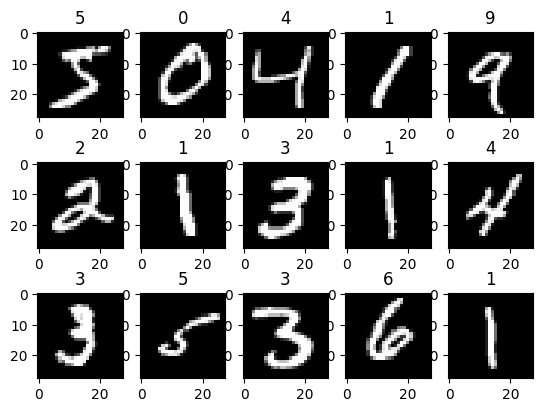

In [4]:
#display some examples from the dataset
import matplotlib.pyplot as plt
%matplotlib inline


#display the first 15 images in the dataset
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(train_data.data[i].numpy(), cmap='gray')
    plt.title('%i' % train_data.targets[i])


In [5]:
import torch

batch_size = 250
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [6]:
model.train_model( train_loader= train_loader,  criterion=nn.BCELoss(), epochs=4)


Epoch [1/4], Step [100/240], Loss: 0.1263
Epoch [1/4], Step [200/240], Loss: 0.0641
Epoch [2/4], Step [100/240], Loss: 0.0555
Epoch [2/4], Step [200/240], Loss: 0.0900
Epoch [3/4], Step [100/240], Loss: 0.0685
Epoch [3/4], Step [200/240], Loss: 0.0609
Epoch [4/4], Step [100/240], Loss: 0.0608
Epoch [4/4], Step [200/240], Loss: 0.0660


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [8]:
generator_losses_train = []
discriminator_losses_train = []
generator_losses_test = []
discriminator_losses_test = []




In [9]:
#normalize the data to be between 0 and 1
normalized_train_data = train_data.data.float() / 255
normalized_test_data = test_data.data.float() / 255


In [73]:


#The main class for GANs 
class generator():
    def __init__(self, input_shape,hidden_shapes,output_shape):

        self.input_shape = input_shape
        self.model = Sequential(
            nn.Linear(1,hidden_shapes[0]),
            nn.SiLU(),
            nn.Linear(hidden_shapes[0],hidden_shapes[1]),
            nn.SiLU(),

            nn.Linear(hidden_shapes[1],output_shape),
            nn.Sigmoid()

        ).to(device)

    def forward(self,img):
        x = self.model(img)
        return x

class discriminator():
    def __init__(self, input_shape,hidden_shapes):
        self.input_shape = input_shape
        self.model = Sequential(
            nn.Linear(input_shape,hidden_shapes[0]),
            nn.SiLU(),
            nn.Linear(hidden_shapes[0],hidden_shapes[1]),
            nn.SiLU(),
            nn.Linear(hidden_shapes[1],1),
            nn.Sigmoid()
        ).to(device)

        

    def forward(self,img):
        x = self.model(img)
        return x

class GAN():
    def __init__(self,img_width,img_height,hidden_shapes_generator,hidden_shapes_discriminator,input_shape = 100, output_shape = None,batch_size= 64):
        if output_shape == None:
            output_shape = img_width*img_height
        self.input_shape = input_shape

        self.generator = generator(input_shape,hidden_shapes_generator,output_shape)
        self.discriminator = discriminator(output_shape,hidden_shapes_discriminator)
        self.loss = nn.MSELoss()
        self.generator_optimizer = torch.optim.Adam(self.generator.model.parameters(),lr=0.002)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.model.parameters(),lr=0.002)
        self.batch_size = batch_size   
        self.real_labels = torch.ones(self.batch_size).reshape(-1, 1).cuda()
        self.fake_labels = torch.zeros(self.batch_size).reshape(-1, 1).cuda()

    def train(self,train_data,epochs=10):
        for epoch in range(epochs):
            noises = (torch.rand(size =(len(train_data),1))*9).cuda().float()
            for i in range(0,len(train_data),self.batch_size):
                # Create noisy input for generator between 0 and 1
                # zero the gradients on each iteration
                self.generator_optimizer.zero_grad()

                # Create noisy input for generator
                # Need float type instead of int

                generated_data = self.generator.model(noises[i:i+self.batch_size])

                # Generate examples of even real data

                true_data = train_data[i:i+self.batch_size].view(-1, 28*28).cuda().float()


                # Train the generator
                # We invert the labels here and don't train the discriminator because we want the generator
                # to make things the discriminator classifies as true.
                generator_discriminator_out = self.discriminator.model(generated_data)
                #check if generator_discriminator_out has nan values

                generator_loss = self.loss(generator_discriminator_out, self.real_labels[:min(self.batch_size,len(generator_discriminator_out))].to(device))
                generator_loss.backward()
                self.generator_optimizer.step()

                # Train the discriminator on the true/generated data
                self.discriminator_optimizer.zero_grad()
                true_discriminator_out = self.discriminator.model(true_data)
                true_discriminator_loss = self.loss(true_discriminator_out, self.real_labels[:min(batch_size,len(true_discriminator_out))].to(device))

                # add .detach() here think about this
                true_discriminator_out = self.discriminator.model(true_data)
                true_discriminator_loss = self.loss(true_discriminator_out, self.real_labels[:min(batch_size,len(true_discriminator_out))].to(device))
                generator_discriminator_out = self.discriminator.model(generated_data.detach())
                generator_discriminator_loss = self.loss(generator_discriminator_out,self.fake_labels[:min(batch_size,len(generator_discriminator_out))].to(device))
                discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
    
                discriminator_loss.backward()
                self.discriminator_optimizer.step()
                generator_losses_train.append(generator_loss.cpu().item())
                discriminator_losses_train.append(discriminator_loss.cpu().item())
            #show some generated examples in a grid 
            if epoch%5 == 0:
                #test the generator on the test set and calculate the loss
                noises = (torch.rand(size =(len(train_data),1))*9).cuda().float()
                generated_data = self.generator.model(noises.to(device))
                true_data = train_data.view(-1,28*28).cuda().float()
                #shuffle the test data
                true_data = true_data[torch.randperm(true_data.size()[0])]
                generator_discriminator_out = self.discriminator.model(generated_data)
                discriminator_discriminator_out = self.discriminator.model(true_data)
                for i in range(0,len(train_data),self.batch_size):
                    generator_loss = self.loss(generator_discriminator_out[i:i+self.batch_size], self.real_labels[:min(self.batch_size,len(train_data)-i)])
                    generator_losses_test.append(generator_loss.item())
                    discriminator_loss = self.loss(discriminator_discriminator_out[i:i+self.batch_size], self.real_labels[:min(self.batch_size,len(train_data)-i)])
                    discriminator_losses_test.append(discriminator_loss.item())

                print("Epoch: ", epoch)
                print("Generator loss: ", generator_loss.item())
                print("Discriminator loss: ", discriminator_loss.item())
                noises = (torch.rand(size =(len(test_data),1))*9).cuda().float()
                generated_data = self.generator.model(noises)

                fig, axs = plt.subplots(1,8, figsize=(20, 2), dpi=80)
                fig.subplots_adjust(wspace=0, hspace=0)

                for i, ax in enumerate(axs.ravel()):
                    ax.imshow(generated_data[i].detach().cpu().numpy().reshape(28, 28), cmap='gray')
                    ax.axis('off')

                plt.show()



In [81]:
gan = GAN(28,28,[10,10,10],[16,16],batch_size=100)

Epoch:  0
Generator loss:  0.9400776624679565
Discriminator loss:  0.008009988814592361


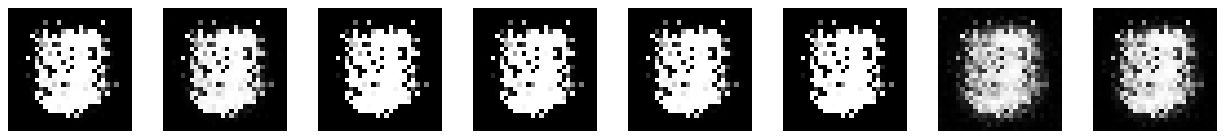

Epoch:  5
Generator loss:  0.999998927116394
Discriminator loss:  8.682889129918436e-11


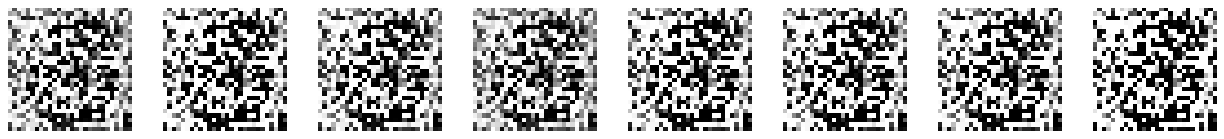

Epoch:  10
Generator loss:  0.9978792071342468
Discriminator loss:  1.2890801372122951e-05


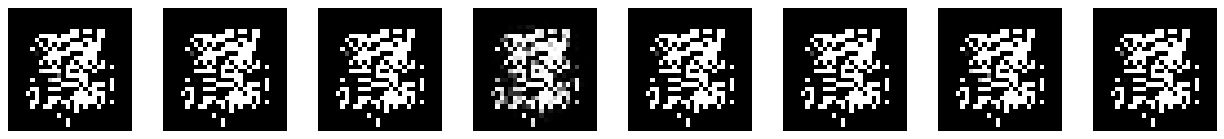

Epoch:  15
Generator loss:  0.9995883107185364
Discriminator loss:  1.3034020867053187e-06


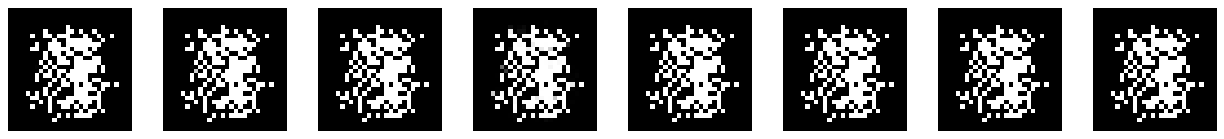

KeyboardInterrupt: 

In [82]:


#train the GAN
gan.train(normalized_train_data,epochs=200)


In [ ]:
for t,u in train_loader: 
    print(t.shape,u.shape)
    break

torch.Size([250, 1, 28, 28]) torch.Size([250])


In [ ]:
model.test_model(test_loader)

tensor([[6.6828e-06, 2.8745e-08, 9.1789e-07,  ..., 1.2505e-10, 1.9107e-03,
         1.1246e-07],
        [1.5071e-05, 6.2731e-12, 1.5169e-08,  ..., 9.9899e-01, 5.1263e-09,
         9.9229e-04],
        [1.0106e-03, 8.2989e-02, 6.5493e-01,  ..., 1.4894e-02, 1.6446e-02,
         3.1310e-04],
        ...,
        [5.8398e-08, 1.2481e-06, 6.2403e-06,  ..., 3.4800e-06, 1.1585e-03,
         5.6044e-04],
        [7.9806e-11, 2.2004e-04, 1.7733e-02,  ..., 4.8541e-07, 7.4499e-06,
         5.6683e-08],
        [2.1342e-05, 1.3061e-06, 3.5233e-06,  ..., 1.5974e-04, 1.0473e-06,
         2.4277e-03]])
tensor([[1.5579e-04, 1.9522e-05, 1.6541e-05,  ..., 1.8456e-03, 1.4071e-02,
         9.6395e-04],
        [1.5501e-12, 1.5861e-03, 1.5953e-06,  ..., 2.0904e-05, 1.6984e-06,
         5.6843e-09],
        [2.2980e-11, 9.9999e-01, 1.7377e-07,  ..., 3.8414e-08, 5.0315e-06,
         3.8717e-08],
        ...,
        [3.2677e-07, 1.6222e-06, 5.9374e-08,  ..., 4.1351e-04, 7.1105e-05,
         7.3735e-03],
   

In [ ]:
model.predict(train_data[0][0])

tensor(5)

tensor(1)


<Figure size 1000x1000 with 0 Axes>

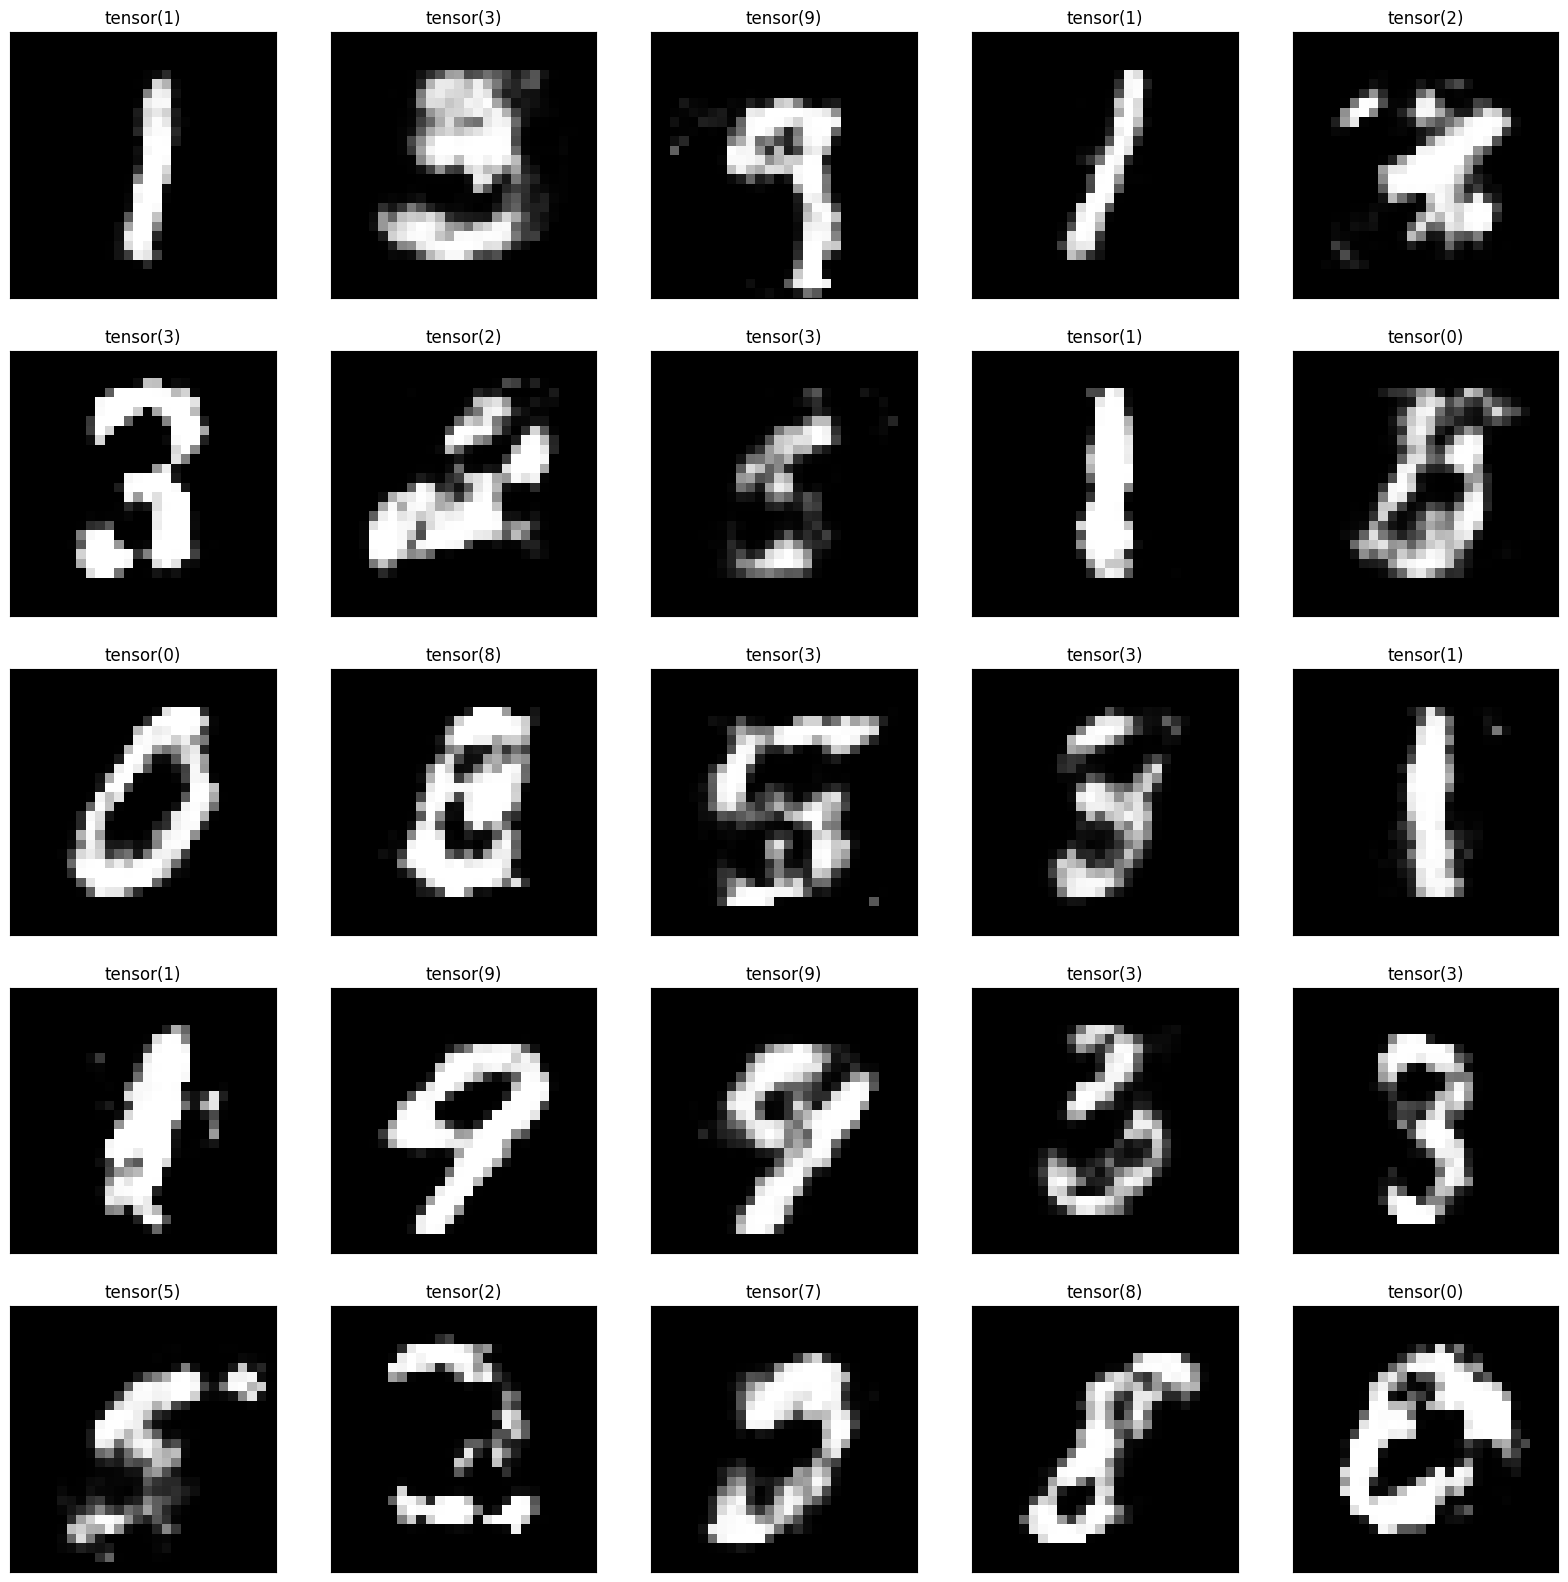

In [ ]:
#test the generator model with the classifier 
import torch
import matplotlib.pyplot as plt
noises = torch.randn(1000, 100).cuda()

generator = gan.generator

output = generator.forward(noises).reshape(-1, 1,28, 28)


print(model.predict(output[3].cpu()))
#plot some with their corrosponding label as a grid 

plt.figure(figsize=(10,10))

fig = plt.figure(figsize=(20,20))
for i in range(25):
    ax = fig.add_subplot(5,5,i+1, xticks=[], yticks=[])
    ax.imshow(output[i].cpu().detach().numpy().reshape(28,28), cmap='gray')
    ax.set_title(model.predict(output[i].cpu()))



In [ ]:
#generate the correct noise for a number 

import torch
class num_generator (nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.num_gen = nn.Sequential(
            nn.Linear(1, 256),
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            
            
            nn.Linear(256, 100),
            nn.Sigmoid())
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
    def forward(self, x):
        return self.num_gen(x)
    
number_generator = num_generator()
loss= nn.BCELoss()
batch_size = 10000
for epoch in range(100):

    #generate some random numbers between 0,9 included in batches of 64

    #generate the random numbers
    train_data = torch.randint(0,9, (batch_size,1))
    #generate the correct noise for the numbers in the batch
    train_noise = number_generator(train_data.float()/10.0)

    generator_output = gan.generator.forward(train_noise.cuda()).reshape(-1,1,28,28)

    classifier_output = model.forward(generator_output.cpu())

    labels = torch.zeros(batch_size,10)

    labels[torch.arange(batch_size), train_data] = 1

    train_loss = loss(classifier_output, labels)

    train_loss.backward()


    number_generator.optimizer.step()

    print(train_loss)

            


tensor(6.2782, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(14.1810, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(17.2178, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(16.1003, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(15.1490, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(12.9458, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(5.7876, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.3349, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(5.2255, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(5.3855, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(4.9962, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(4.8952, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(4.8543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(4.8790, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(4.8779, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(4.8592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(4.8651, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(4.8623, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(4.8850, grad_fn=

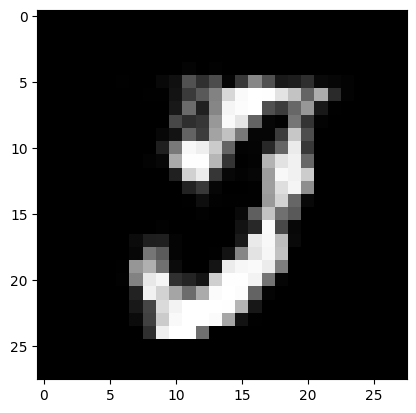

In [ ]:
import torch
generated_noise = number_generator.forward(torch.randn(1))

output = generator.forward(generated_noise.cuda()).reshape(-1, 1,28, 28)

plt.imshow(output.cpu().detach().numpy().reshape(28,28), cmap='gray')

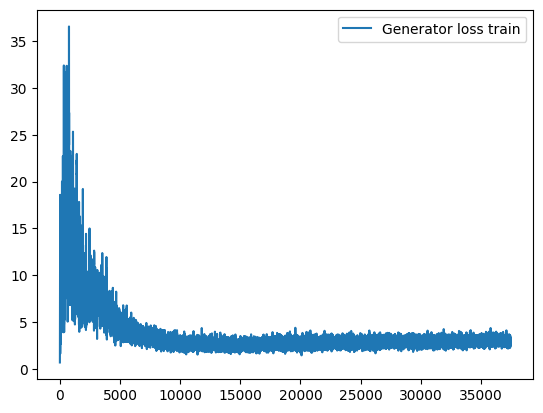

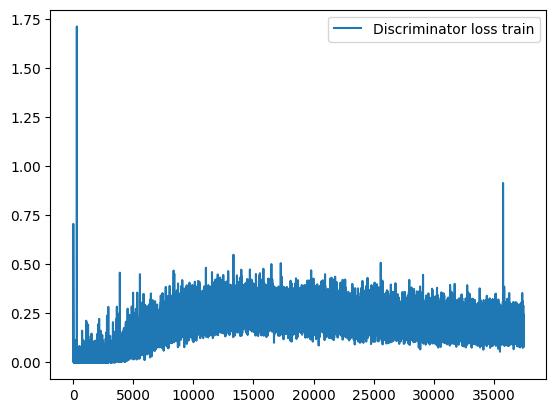

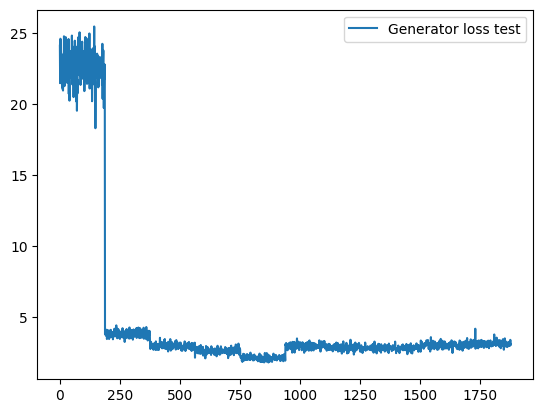

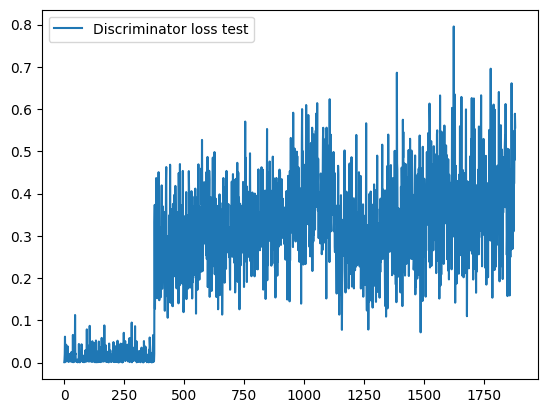

In [ ]:
#plot the losses
plt.plot(generator_losses_train, label='Generator loss train')
plt.legend()
plt.show()
plt.plot(discriminator_losses_train, label='Discriminator loss train')
plt.legend()
plt.show()
plt.plot(generator_losses_test, label='Generator loss test')
plt.legend()
plt.show()
plt.plot(discriminator_losses_test, label='Discriminator loss test')
plt.legend()
plt.show()


In [ ]:
import math 
#import Tuple List
from typing import Tuple, List
import numpy as np 

In [ ]:

def create_binary_list_from_int(number: int) -> List[int]:
    if number < 0 or type(number) is not int:
        raise ValueError("Only Positive integers are allowed")

    return [int(x) for x in list(bin(number))[2:]]

In [ ]:

def generate_even_data(max_int: int, batch_size: int=16) -> Tuple[List[int], List[List[int]]]:
    # Get the number of binary places needed to represent the maximum number
    max_length = int(math.log(max_int, 2))

    # Sample batch_size number of integers in range 0-max_int
    sampled_integers = np.random.randint(0, int(max_int / 2), batch_size)

    # create a list of labels all ones because all numbers are even
    labels = [1] * batch_size

    # Generate a list of binary numbers for training.
    data = [create_binary_list_from_int(int(x * 2)) for x in sampled_integers]
    data = [([0] * (max_length - len(x))) + x for x in data]

    return labels, data

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_length: int):
        super(Discriminator, self).__init__()
        self.dense = nn.Linear(int(input_length), 1);
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense(x))

In [ ]:

class Generator(nn.Module):

    def __init__(self, input_length: int):
        super(Generator, self).__init__()
        self.dense_layer = nn.Linear(int(input_length), int(input_length))
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense_layer(x))

In [ ]:
import math

import torch
import torch.nn as nn


def train(max_int: int = 128, batch_size: int = 16, training_steps: int = 500):
    input_length = int(math.log(max_int, 2))

    # Models
    generator = Generator(input_length)
    discriminator = Discriminator(input_length)

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

    # loss
    loss = nn.BCELoss()

    for i in range(training_steps):
        # zero the gradients on each iteration
        generator_optimizer.zero_grad()

        # Create noisy input for generator
        # Need float type instead of int
        noise = torch.randint(0, 2, size=(batch_size, input_length)).float()
        generated_data = generator(noise)

        # Generate examples of even real data
        true_labels, true_data = generate_even_data(max_int, batch_size=batch_size)
        true_labels = torch.tensor(true_labels).float()
        true_data = torch.tensor(true_data).float()

        # Train the generator
        # We invert the labels here and don't train the discriminator because we want the generator
        # to make things the discriminator classifies as true.
        generator_discriminator_out = discriminator(generated_data)
        generator_loss = loss(generator_discriminator_out, true_labels.reshape(-1, 1))
        generator_loss.backward()
        generator_optimizer.step()

        # Train the discriminator on the true/generated data
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)
        true_discriminator_loss = loss(true_discriminator_out, true_labels.reshape(-1, 1))

        # add .detach() here think about this
        # Train the discriminator
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)
        true_discriminator_loss = loss(true_discriminator_out, torch.ones(batch_size).reshape(-1, 1))
        generator_discriminator_out = discriminator(generated_data.detach())
        generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros(batch_size).reshape(-1, 1))
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        print (generator_discriminator_loss, true_discriminator_loss)
        discriminator_loss.backward()
        discriminator_optimizer.step()


In [ ]:
#train the GAN
train()


tensor(0.5149, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1.0731, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5195, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.9948, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5236, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.9331, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5217, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1.0251, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5273, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1.0586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5296, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.9750, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5318, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.9082, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5383, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.8868, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5376, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.9613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5395, grad_fn=<Bina